In [35]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


#df = pd.read_csv('./Dataset_model.csv')

df_past = pd.read_csv('./Dataset_model.csv')
df_new = pd.read_csv('./Submit.csv', sep=';')

df_new["acertou"] = 0

df = pd.concat([df_past, df_new])
df.reset_index(inplace=True, drop=True)

In [36]:
# imports

import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, OneHotEncoder
from starsmodelcreation.stars_pipeline import StarsPipeline
from sklearn.ensemble import RandomForestClassifier
from starsmodelcreation.stars_tuning import StarsHyperparameterTuning
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import randint
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from xgboost import XGBClassifier
from starsmodelcreation.stars_transforms import LogTransformer

In [37]:
df["created_at"] = pd.to_datetime(df['created_at'])

In [38]:
class Student():
    
    def __init__(self, student_id, df):
        self.student_id = student_id
        self.df = df[["acertou", "modality_id", "difficulty",
                      "knowledge_area_id", "gp:previous experience",
                      "gp:segment", "created_at"]]
        
        self.df["created_at_shift_1"] = self.df["created_at"].shift(1)
        self.df["created_at_shift_3"] = self.df["created_at"].shift(3)
        self.df["created_at_shift_5"] = self.df["created_at"].shift(5)
        self.df["created_at_shift_10"] = self.df["created_at"].shift(10)
        self.df["created_at_shift_20"] = self.df["created_at"].shift(20)
        
        self.df["diff_time_1"] = self.df["created_at"] - self.df["created_at_shift_1"]
        self.df["diff_time_3"] = self.df["created_at"] - self.df["created_at_shift_3"]
        self.df["diff_time_5"] = self.df["created_at"] - self.df["created_at_shift_5"]
        self.df["diff_time_10"] = self.df["created_at"] - self.df["created_at_shift_10"]
        self.df["diff_time_20"] = self.df["created_at"] - self.df["created_at_shift_20"]
        
        self.df["diff_time_1"] = self.df["diff_time_1"].apply(lambda x: x.seconds/60)
        self.df["diff_time_3"] = self.df["diff_time_3"].apply(lambda x: x.seconds/60)
        self.df["diff_time_5"] = self.df["diff_time_5"].apply(lambda x: x.seconds/60)
        self.df["diff_time_10"] = self.df["diff_time_10"].apply(lambda x: x.seconds/60)
        self.df["diff_time_20"] = self.df["diff_time_20"].apply(lambda x: x.seconds/60)
        
        self.df.drop(columns=["created_at", "created_at_shift_1", "created_at_shift_3", "created_at_shift_5",
                             "created_at_shift_10", "created_at_shift_20"], inplace=True)
        
    def calculate_dif_acumulada(self):
        self.df["dificuldade_acumulada"] = self.df["difficulty"].expanding(min_periods=1).mean()
        self.df["dificuldade_acumulada_last_2"] = self.df["difficulty"].rolling(2).mean()
        self.df["dificuldade_acumulada_last_5"] = self.df["difficulty"].rolling(5).mean()
        self.df["dificuldade_acumulada_last_10"] = self.df["difficulty"].rolling(10).mean()
        self.df["dificuldade_acumulada_last_20"] = self.df["difficulty"].rolling(20).mean()
        
    def calculate_score_acumulado(self):
        self.df["score_acumulado1"] = self.df["acertou"][self.df["difficulty"] == 1].shift(1).expanding().mean()
        self.df["score_acumulado2"] = self.df["acertou"][self.df["difficulty"] == 2].shift(1).expanding().mean()
        self.df["score_acumulado3"] = self.df["acertou"][self.df["difficulty"] == 3].shift(1).expanding().mean()
        self.df["score_acumulado4"] = self.df["acertou"][self.df["difficulty"] == 4].shift(1).expanding().mean()
        self.df["score_acumulado5"] = self.df["acertou"][self.df["difficulty"] == 5].shift(1).expanding().mean()

    def calculate_score_acumulado_last_10(self):
        self.df["score_acumulado1_last10"] = self.df["acertou"][self.df["difficulty"] == 1].rolling(10, closed="left").mean()
        self.df["score_acumulado2_last10"] = self.df["acertou"][self.df["difficulty"] == 2].rolling(10, closed="left").mean()
        self.df["score_acumulado3_last10"] = self.df["acertou"][self.df["difficulty"] == 3].rolling(10, closed="left").mean()
        self.df["score_acumulado4_last10"] = self.df["acertou"][self.df["difficulty"] == 4].rolling(10, closed="left").mean()
        self.df["score_acumulado5_last10"] = self.df["acertou"][self.df["difficulty"] == 5].rolling(10, closed="left").mean()
        
        self.df["score_acumulado1_last20"] = self.df["acertou"][self.df["difficulty"] == 1].rolling(20, closed="left").mean()
        self.df["score_acumulado2_last20"] = self.df["acertou"][self.df["difficulty"] == 2].rolling(20, closed="left").mean()
        self.df["score_acumulado3_last20"] = self.df["acertou"][self.df["difficulty"] == 3].rolling(20, closed="left").mean()
        self.df["score_acumulado4_last20"] = self.df["acertou"][self.df["difficulty"] == 4].rolling(20, closed="left").mean()
        self.df["score_acumulado5_last20"] = self.df["acertou"][self.df["difficulty"] == 5].rolling(20, closed="left").mean()
        
        self.df["score_acumulado1_last5"] = self.df["acertou"][self.df["difficulty"] == 1].rolling(5, closed="left").mean()
        self.df["score_acumulado2_last5"] = self.df["acertou"][self.df["difficulty"] == 2].rolling(5, closed="left").mean()
        self.df["score_acumulado3_last5"] = self.df["acertou"][self.df["difficulty"] == 3].rolling(5, closed="left").mean()
        self.df["score_acumulado4_last5"] = self.df["acertou"][self.df["difficulty"] == 4].rolling(5, closed="left").mean()
        self.df["score_acumulado5_last5"] = self.df["acertou"][self.df["difficulty"] == 5].rolling(5, closed="left").mean()
        
        self.df["score_acumulado1_last2"] = self.df["acertou"][self.df["difficulty"] == 1].rolling(2, closed="left").mean()
        self.df["score_acumulado2_last2"] = self.df["acertou"][self.df["difficulty"] == 2].rolling(2, closed="left").mean()
        self.df["score_acumulado3_last2"] = self.df["acertou"][self.df["difficulty"] == 3].rolling(2, closed="left").mean()
        self.df["score_acumulado4_last2"] = self.df["acertou"][self.df["difficulty"] == 4].rolling(2, closed="left").mean()
        self.df["score_acumulado5_last2"] = self.df["acertou"][self.df["difficulty"] == 5].rolling(2, closed="left").mean()
    
    def acertos_seguidos(self):
        self.df["acertos_seguidos_2"] = self.df["acertou"].rolling(2, closed="left").sum()
        self.df["acertos_seguidos_5"] = self.df["acertou"].rolling(5, closed="left").sum()
        self.df["acertos_seguidos_10"] = self.df["acertou"].rolling(10, closed="left").sum()
        self.df["acertos_seguidos_20"] = self.df["acertou"].rolling(20, closed="left").sum()
        
    def forwardfill(self):
        
        self.df = self.df.fillna(method="ffill")
        
    def set_types(self):
        col_ = ["gp:segment", "modality_id", "gp:previous experience", "knowledge_area_id"]
        self.df[col_] = self.df[col_].astype("str")
        
    def split_train_test(self):
        
        self.X_train = self.df.iloc[0:-6]
        self.X_validation = self.df.iloc[-6:-1]
        self.X_test = self.df.iloc[-1]
        
        
        #self.X_validation = self.X_validation.to_frame().T
        self.X_test = self.X_test.to_frame().T
        
        self.y_train = self.df["acertou"].iloc[0:-6]
        self.y_validation = self.df["acertou"].iloc[-6:-1]
        self.y_test = self.df["acertou"].iloc[-1]

        
    def main(self):
        self.calculate_dif_acumulada()
        self.calculate_score_acumulado()
        self.calculate_score_acumulado_last_10()
        self.acertos_seguidos()
        
        self.forwardfill()
        self.set_types()
        
        self.df = self.df.iloc[30:]
        
        self.split_train_test()

In [39]:
list_students_ids = df["novo_user_id"].unique()

In [40]:
def create_dataset(list_students):
    
    y_train = []
    y_validation = []
    y_test = []
    
    X_train = pd.DataFrame()
    X_validation = pd.DataFrame()
    X_test = pd.DataFrame()

    for student in list_students:

        df_aux_train = student.X_train.loc[:, ~student.X_train.columns.isin(['acertou'])]
        X_train = pd.concat([X_train, df_aux_train])
        
        df_aux_validation = student.X_validation.loc[:, ~student.X_validation.columns.isin(['acertou'])]
        X_validation = pd.concat([X_validation, df_aux_validation])
        
        df_aux_test = student.X_test.loc[:, ~student.X_test.columns.isin(['acertou'])]
        X_test = pd.concat([X_test, df_aux_test])
        
        
        y_train.append(list(student.X_train["acertou"]))
        y_validation.append(list(student.X_validation["acertou"]))
        y_test.append(list(student.X_test["acertou"]))
        
    X_train.reset_index(inplace=True, drop=True)
    X_validation.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    
    y_train = [item for sublist in y_train for item in sublist]
    y_validation = [item for sublist in y_validation for item in sublist]
    y_test = [item for sublist in y_test for item in sublist]
        
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [41]:
from sklearn.metrics import f1_score

def objective(space):
    model = XGBClassifier(n_estimators =space['n_estimators'],
                             num_parallel_tree = 1,
                             subsample = 0.8,
                             learning_rate = space['learning_rate'],
                             max_depth = space['max_depth'],
                             gamma = space['gamma'],
                             reg_lambda = space['reg_lambda'],
                             reg_alpha = space['reg_alpha'],
                             scale_pos_weight = space["scale_pos_weight"])

    #fitting the model
    model.fit(X_train, y_train, verbose=False)

    #metric
    y_pred_val = model.predict(X_validation)

    metric = f1_score(y_validation, y_pred_val)

    return{'loss':-1*metric, 'status': STATUS_OK }

In [42]:
list_models = []
list_pred = []

for i in range(0, 20):
    
    print(i)
    
    list_students_ids = list(range(1 + i*1000, i*1000 + 1000 + 1))

    list_students = []

    for idx in list_students_ids:
        student = Student(idx, df[df["novo_user_id"] == idx])
        student.main()
        list_students.append(student)
        
    X_train, X_validation, X_test, y_train, y_validation, y_test = create_dataset(list_students)
    
    # data transformation

    col = ["knowledge_area_id", "gp:previous experience", "modality_id", "gp:segment"]

    encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=5, sparse=False)
    encoder.fit(X_train[col])

    # cat
    X_train_cat = encoder.transform(X_train[col])
    X_validation_cat = encoder.transform(X_validation[col])
    X_test_cat = encoder.transform(X_test[col])

    X_train_cat = pd.DataFrame(X_train_cat, columns=encoder.get_feature_names_out())
    X_validation_cat = pd.DataFrame(X_validation_cat, columns=encoder.get_feature_names_out())
    X_test_cat = pd.DataFrame(X_test_cat, columns=encoder.get_feature_names_out())

    #num
    X_train_num = X_train.loc[:, ~X_train.columns.isin(col)]
    X_validation_num = X_validation.loc[:, ~X_validation.columns.isin(col)]
    X_test_num = X_test.loc[:, ~X_test.columns.isin(col)]

    #join both
    X_train = pd.concat([X_train_cat, X_train_num], axis=1)
    X_validation = pd.concat([X_validation_cat, X_validation_num], axis=1)
    X_test = pd.concat([X_test_cat, X_test_num], axis=1)
    
    X_train = X_train.fillna(0)
    X_validation = X_validation.fillna(0)
    X_test = X_test.fillna(0)
    
    space ={'max_depth': hp.randint("max_depth", 1, 10),
            'gamma' : hp.uniform('gamma', 1.0, 5.0),
            'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
            'reg_alpha' : hp.uniform('reg_alpha', 0, 10),
            'learning_rate' :hp.uniform('learning_rate', 0.001 , 0.2),
            'n_estimators' :hp.randint('n_estimators', 10, 200),
            "scale_pos_weight": hp.uniform("scale_pos_weight", 0.1, 10)
        }


    trials = Trials()

    rstate = np.random.default_rng(i)

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials,
                rstate=rstate)

    print(best)
    
    # make a prediction
    model = XGBClassifier(n_estimators =best['n_estimators'],
                          num_parallel_tree = 1,
                          subsample = 0.8,
                          learning_rate = best['learning_rate'],
                          max_depth = best['max_depth'],
                          gamma = best['gamma'],
                          reg_lambda = best['reg_lambda'],
                          reg_alpha = best['reg_alpha'],
                          scale_pos_weight = best["scale_pos_weight"])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    list_models.append(model)
    
    list_pred.append(y_pred)
    
    print(f1_score(y_test, y_pred))

0
100%|██████████| 100/100 [19:10<00:00, 11.51s/trial, best loss: -0.8387332521315469]
{'gamma': 1.0313115745651158, 'learning_rate': 0.18995172330166793, 'max_depth': 7, 'n_estimators': 51, 'reg_alpha': 3.2733064323456023, 'reg_lambda': 6.681857000808238, 'scale_pos_weight': 1.7366902472372143}
0.0
1
100%|██████████| 100/100 [20:35<00:00, 12.35s/trial, best loss: -0.8336453263446898]
{'gamma': 4.979354607603163, 'learning_rate': 0.07629564443798689, 'max_depth': 7, 'n_estimators': 172, 'reg_alpha': 4.066297562175072, 'reg_lambda': 4.616398859294036, 'scale_pos_weight': 1.4754979232399443}
0.0
2
100%|██████████| 100/100 [16:59<00:00, 10.19s/trial, best loss: -0.8407690411634212]
{'gamma': 1.0368179584098218, 'learning_rate': 0.10330231178981214, 'max_depth': 3, 'n_estimators': 153, 'reg_alpha': 7.246436797894404, 'reg_lambda': 4.861870345474593, 'scale_pos_weight': 1.3793653551246263}
0.0
3
100%|██████████| 100/100 [21:15<00:00, 12.76s/trial, best loss: -0.8321167883211679]
{'gamma': 4

In [43]:
list_pred = [item for sublist in list_pred for item in sublist]

In [44]:
y_pred = pd.DataFrame(list_pred)

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

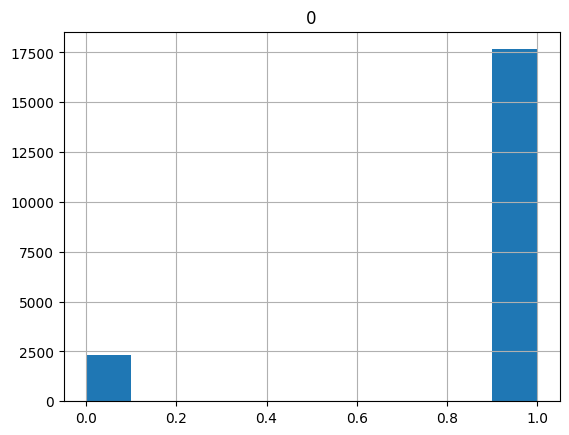

In [45]:
y_pred.hist()

In [46]:
y_pred.to_csv('./final_primeiro_win.csv', index=False, header=False)